# Notebook for the Quant Track
### Author: Marcello Maugeri
#### RNDM Tournament @ Encode London 2024

### Getting started:
- Create a virtual environment with `python3.11 -m venv venv` (tested on Python 3.11, but Python 3.12 should be fine)
- Activate it with `source venv/bin/activate`
- Before running the notebook, please be sure to read the README.md in this folder, as it explains how to get data from BigQuery. In any case, pre-fetched data are already present in the `data` folder.
- Run the notebook (be sure to select the venv as kernel)

In [2]:
#This will install all the requirements 
!pip install -r requirements.txt

In [26]:
#Imports
import pandas as pd
import numpy as np
import glob
import os
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from ta.trend import ADXIndicator

### Data Selection and Aggregation

The objective of this notebook is to analyze data from Aave V3 in the Polygon network for the tokens WETH and USDC.

The data is composed of two parts:
- **sample** contains data obtained from BigQuery providing `liquidity_rate`,`stable_borrow_rate`,`variable_borrow_rate`,`liquidity_index`,`variable_borrow_index` for both tokens.
In particular, the addresses are:
    - `0x2791Bca1f2de4661ED88A30C99A7a9449Aa84174` for `usdc`
    - `0x7ceB23fD6bC0adD59E62ac25578270cFf1b9f619` for `weth`
- **volatility_data_june_2024** contains the assets value for `usdc` and `weth` obtained from the pycoingecko API.

Since the **sample** data are measured every minute, the first step is to standardize the volatility data into a table with a timestamp for every minute, aligning it with the sample data.

The output would be found in `../data/WETH_USDC_Prices.csv`.

In [4]:
# Function to read JSON data from a file
def read_prices_from_file(filename):
    try:
        with open(filename, 'r') as file:
            data = json.load(file)
        return data['prices']
    except FileNotFoundError:
        print(f"Error: The file '{filename}' was not found.")
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from file '{filename}': {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Function to create a DataFrame from price data
def create_price_dataframe(prices):
    # Convert timestamps to datetime and create a DataFrame
    timestamps = [datetime.fromtimestamp(item[0] / 1000) for item in prices]
    prices_values = [item[1] for item in prices]
    df = pd.DataFrame({'timestamp': timestamps, 'price': prices_values})
    df.set_index('timestamp', inplace=True)
    return df

# Read WETH and USDC prices
weth_prices = read_prices_from_file('../data/volatility_data_june_2024/aave-polygon-weth.json')
usdc_prices = read_prices_from_file('../data/volatility_data_june_2024/aave-polygon-usdc.json')

# Create DataFrames
weth_daily_daily_daily_df = create_price_dataframe(weth_prices)
usdc_df = create_price_dataframe(usdc_prices)

# Define the time range for the entire month of June 2024
start_time = datetime(2024, 6, 1, 0, 0)
end_time = datetime(2024, 6, 30, 23, 59)
all_times = pd.date_range(start=start_time, end=end_time, freq='T')

# Initialize indices and current price holders
weth_idx = 0
usdc_idx = 0
weth_len = len(weth_df)
usdc_len = len(usdc_df)

# Create a results list
results = []

# Initialize with the first values from the DataFrames
current_weth = weth_df.iloc[0]['price'] if weth_len > 0 else None
current_usdc = usdc_df.iloc[0]['price'] if usdc_len > 0 else None

# Loop through each minute in the time range
for current_time in all_times:
    # Check for current WETH price if within bounds
    if weth_idx < weth_len and weth_df.index[weth_idx] <= current_time:
        current_weth = weth_df.iloc[weth_idx]['price']
        weth_idx += 1

    # Check for current USDC price if within bounds
    if usdc_idx < usdc_len and usdc_df.index[usdc_idx] <= current_time:
        current_usdc = usdc_df.iloc[usdc_idx]['price']
        usdc_idx += 1

    # Add the current time and prices to results
    results.append([current_time, current_weth, current_usdc])

# Create a final DataFrame
df = pd.DataFrame(results, columns=['timestamp', 'WETH', 'USDC'])

# Format the timestamp for the output
df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Save to CSV
df.to_csv('../data/WETH_USDC_Prices.csv', index=False, header=['', 'WETH', 'USDC'])

df.head()

/var/folders/ch/f52gc87d5_7b95m4hg7qfbj80000gn/T/ipykernel_53810/3214608902.py:34: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  all_times = pd.date_range(start=start_time, end=end_time, freq='T')


,timestamp,WETH,USDC
0,2024-06-01 00:00:00,3769.771717,1.00069
1,2024-06-01 00:01:00,3769.771717,1.00069
2,2024-06-01 00:02:00,3769.771717,1.00069
3,2024-06-01 00:03:00,3769.771717,1.00069
4,2024-06-01 00:04:00,3769.771717,1.00069


Now we can join the current dataframe with the liquidity and borrow rates for both tokens from the `sample` folder.

In [5]:
folder_path="../data/sample/"

# --- Step 1: Process 'weth' data ---

# Create an empty list to store the 'weth' DataFrames
weth_dfs = []

# Loop through all 'weth' CSV files in the folder
for file in glob.glob(folder_path + '*-0x7ceb23fd6bc0add59e62ac25578270cff1b9f619-*.minute.csv'):  # Filter for 'weth' files
    # Read the CSV file into a pandas DataFrame
    temp_df = pd.read_csv(file)

    # Rename columns by prepending 'weth'
    columns_to_rename = {
        'liquidity_rate': 'weth_liquidity_rate',
        'stable_borrow_rate': 'weth_stable_borrow_rate',
        'variable_borrow_rate': 'weth_variable_borrow_rate',
        'liquidity_index': 'weth_liquidity_index',
        'variable_borrow_index': 'weth_variable_borrow_index'
    }
    temp_df = temp_df.rename(columns=columns_to_rename)

    # Add the DataFrame to the list
    weth_dfs.append(temp_df)

# Concatenate all 'weth' DataFrames
weth_combined_df = pd.concat(weth_dfs)

# Merge the 'weth' DataFrame
weth_combined_df = pd.merge(df, weth_combined_df, left_on='timestamp', right_on='block_timestamp').drop("block_timestamp", axis=1)

weth_combined_df.head(5)

,timestamp,WETH,USDC,weth_liquidity_rate,weth_stable_borrow_rate,weth_variable_borrow_rate,weth_liquidity_index,weth_variable_borrow_index
0,2024-06-01 00:00:00,3769.771717,1.00069,0.004649,0.076128,0.020831,1.010326,1.043067
1,2024-06-01 00:01:00,3769.771717,1.00069,0.004649,0.076128,0.020831,1.010326,1.043067
2,2024-06-01 00:02:00,3769.771717,1.00069,0.004649,0.076128,0.020831,1.010326,1.043067
3,2024-06-01 00:03:00,3769.771717,1.00069,0.004649,0.076128,0.020831,1.010326,1.043067
4,2024-06-01 00:04:00,3769.771717,1.00069,0.004649,0.076128,0.020831,1.010326,1.043067


In [6]:
# --- Step 2: Process 'usdc' data ---

# Create an empty list to store the 'usdc' DataFrames
usdc_dfs = []

# Loop through all 'usdc' CSV files in the folder
for file in glob.glob(folder_path + '*-0x2791bca1f2de4661ed88a30c99a7a9449aa84174-*.minute.csv'):  # Filter for 'usdc' files
    # Read the CSV file into a pandas DataFrame
    temp_df = pd.read_csv(file)

    # Rename columns by prepending 'usdc'
    columns_to_rename = {
        'liquidity_rate': 'usdc_liquidity_rate',
        'stable_borrow_rate': 'usdc_stable_borrow_rate',
        'variable_borrow_rate': 'usdc_variable_borrow_rate',
        'liquidity_index': 'usdc_liquidity_index',
        'variable_borrow_index': 'usdc_variable_borrow_index'
    }
    temp_df = temp_df.rename(columns=columns_to_rename)
    
    # Add the DataFrame to the list
    usdc_dfs.append(temp_df)

# Concatenate all 'weth' DataFrames
usdc_combined_df = pd.concat(usdc_dfs)

# Merge the 'weth' DataFrame
all_combined_df = pd.merge(weth_combined_df, usdc_combined_df, left_on='timestamp', right_on='block_timestamp').drop("block_timestamp", axis=1)

all_combined_df.to_csv('../data/all_combined.csv', index=False)

all_combined_df.head(5)

,timestamp,WETH,USDC,weth_liquidity_rate,weth_stable_borrow_rate,weth_variable_borrow_rate,weth_liquidity_index,weth_variable_borrow_index,usdc_liquidity_rate,usdc_stable_borrow_rate,usdc_variable_borrow_rate,usdc_liquidity_index,usdc_variable_borrow_index
0,2024-06-01 00:00:00,3769.771717,1.00069,0.004649,0.076128,0.020831,1.010326,1.043067,0.066019,0.114905,0.098100,1.093715,1.136930
1,2024-06-01 00:01:00,3769.771717,1.00069,0.004649,0.076128,0.020831,1.010326,1.043067,0.066021,0.114905,0.098102,1.093716,1.136931
2,2024-06-01 00:02:00,3769.771717,1.00069,0.004649,0.076128,0.020831,1.010326,1.043067,0.066022,0.114905,0.098102,1.093716,1.136931
3,2024-06-01 00:03:00,3769.771717,1.00069,0.004649,0.076128,0.020831,1.010326,1.043067,0.066022,0.114905,0.098102,1.093716,1.136931
4,2024-06-01 00:04:00,3769.771717,1.00069,0.004649,0.076128,0.020831,1.010326,1.043067,0.066022,0.114905,0.098102,1.093716,1.136931


In [7]:
# Now, to avoid confusion, let's rename the dataframe
df = all_combined_df
# Let's see a descriptive statistics
df.describe()

,WETH,USDC,weth_liquidity_rate,weth_stable_borrow_rate,weth_variable_borrow_rate,weth_liquidity_index,weth_variable_borrow_index,usdc_liquidity_rate,usdc_stable_borrow_rate,usdc_variable_borrow_rate,usdc_liquidity_index,usdc_variable_borrow_index
count,43200.000000,43200.000000,43200.000000,43200.000000,43200.000000,43200.000000,43200.000000,43200.000000,43200.000000,43200.000000,43200.000000,43200.000000
mean,3570.665013,0.999954,0.004560,0.074681,0.020376,1.010536,1.043958,0.067674,0.122247,0.104175,1.097142,1.142252
std,156.428130,0.001039,0.000265,0.002695,0.000938,0.000121,0.000510,0.021655,0.020302,0.029533,0.001758,0.002784
min,3269.471031,0.990930,0.004071,0.069833,0.018662,1.010326,1.043067,0.044919,0.114028,0.080557,1.093715,1.136930
25%,3445.561727,0.999620,0.004454,0.075762,0.020529,1.010432,1.043515,0.056021,0.114513,0.090252,1.095776,1.140069
50%,3525.877361,0.999981,0.004639,0.076111,0.020816,1.010540,1.043967,0.063216,0.114796,0.095928,1.097365,1.142503
75%,3692.368400,1.000279,0.004734,0.076285,0.020960,1.010641,1.044412,0.067282,0.114958,0.099165,1.098674,1.144660
max,3873.330017,1.013684,0.005036,0.076834,0.021413,1.010742,1.044815,0.250051,0.314232,0.365643,1.099853,1.146706


#### General observation
- **Count**: We have 43200 data points for each variable, which is a good amount of data for analysis. This represents minute-level data for the entire month of June (30 days * 24 hours * 60 minutes = 43,200 minutes).
- **Mean vs. Median (50%)**: For most variables, the mean and median are quite close, suggesting a roughly symmetrical distribution of the data. However, there are some exceptions (like usdc_stable_borrow_rate, and usdc_variable_borrow_rate), where the mean is higher than the median, indicating a right-skewed distribution (some larger values are pulling the mean up).
- **WETH**: The average price of WETH in June was around 3570.67, with a standard deviation of 156.43, indicating some price fluctuation. The minimum and maximum values show the price range during the month.
- **USDC**: As expected, the USDC price remains relatively stable around 1.00. The small standard deviation confirms this stability.
- **Liquidity Rates** (weth_liquidity_rate, usdc_liquidity_rate): These rates represent the returns earned by liquidity providers. The average liquidity rate for WETH is much lower (0.00456) than for USDC (0.067674). The large standard deviation and the max value for usdc_liquidity_rate suggest significant variability and potentially some outliers or unusual spikes in the USDC liquidity rate.
- **Borrow Rates** (weth_stable_borrow_rate, weth_variable_borrow_rate, usdc_stable_borrow_rate, usdc_variable_borrow_rate): These rates show the cost of borrowing. In general, USDC borrow rates are higher than WETH borrow rates. The variability in borrow rates is also higher for USDC, especially for the stable borrow rate.
- **Liquidity and Borrow Indices** (weth_liquidity_index, weth_variable_borrow_index, usdc_liquidity_index, usdc_variable_borrow_index): These indices track the cumulative changes in liquidity and borrow rates over time. The relatively small standard deviations indicate that these indices generally trend upwards gradually.

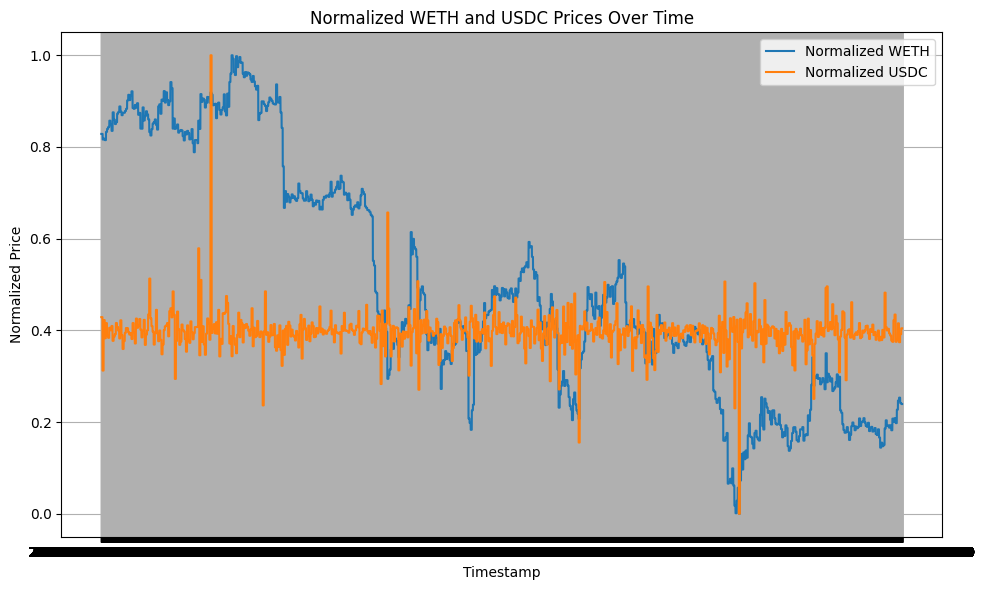

In [8]:
# Extract the 'WETH' and 'USDC' columns
weth_prices = df['WETH']
usdc_prices = df['USDC']

# Normalize the prices using Min-Max scaling
normalized_weth = (weth_prices - weth_prices.min()) / (weth_prices.max() - weth_prices.min())
normalized_usdc = (usdc_prices - usdc_prices.min()) / (usdc_prices.max() - usdc_prices.min())

# --- Plot the normalized prices ---
plt.figure(figsize=(10, 6))

# Plot normalized WETH prices
plt.plot(df['timestamp'], normalized_weth, label='Normalized WETH')

# Plot normalized USDC prices
plt.plot(df['timestamp'], normalized_usdc, label='Normalized USDC')

# Set plot labels and title
plt.xlabel('Timestamp')
plt.ylabel('Normalized Price')
plt.title('Normalized WETH and USDC Prices Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

At first sight there is no clear correlation between the two variables. To quantify this, we can calculate the Pearson coefficient.

In [9]:
# Calculate the Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(normalized_weth, normalized_usdc)

# Print the results
print(f"Pearson Correlation between normalized WETH and USDC prices: {correlation}")
print(f"P-value: {p_value}")

Pearson Correlation between normalized WETH and USDC prices: 0.10300329610292301
P-value: 3.284392198413366e-102


- The **Pearson Correlation Coefficient** shows a weak positive correlation. A positive correlation means that that as the normalized price of WETH increases, the normalized price of USDC tends to increase slightly as well (and vice versa).
- The **p-value** is extremely small (essentially zero). This means that the observed correlation is highly statistically significant. In other words, it is very unlikely to have occurred by chance alone.
The agent could leverage this indicator for market prediction

The next step is to measure two important indicators in trading strategies.
The first metric is the **EMA Bearish Crossover**, a technical analysis signal that indicates a potential downward trend or selling opportunity. It occurs when a short-term Exponential Moving Average (EMA) crosses below a longer-term EMA. This crossover suggests that the momentum is shifting from bullish (upward) to bearish (downward), which traders often interpret as a sell signal. Since we have data for one month only, we will consider a popular strategy which is the 5-8-13 EMA. In brief, when the 5-EMA crosses above the 8 and 13 EMAs, it suggests a rising bullish momentum (). When the opposite happens, it indicates bearish momentum.

In [10]:
# Create a copy of 'df'
daily_df = df.copy()

# Ensure 'timestamp' is a DatetimeIndex before resampling
daily_df['timestamp'] = pd.to_datetime(daily_df['timestamp'])
daily_df = daily_df.set_index('timestamp')

# Resample to daily frequency and take the first row of each day
daily_df = daily_df.resample('D').first()

# Reset the index to have 'timestamp' as a column again
daily_df = daily_df.reset_index()

# Now you can convert 'timestamp' to datetime if needed
daily_df['timestamp'] = pd.to_datetime(daily_df['timestamp']) 

# --- Calculate EMAs ---

# Calculate the 5, 8, and 13 EMA for WETH liquidity rate
daily_df['weth_liquidity_rate_ema_5'] = daily_df['weth_liquidity_rate'].ewm(span=5, adjust=False).mean()
daily_df['weth_liquidity_rate_ema_8'] = daily_df['weth_liquidity_rate'].ewm(span=8, adjust=False).mean()
daily_df['weth_liquidity_rate_ema_13'] = daily_df['weth_liquidity_rate'].ewm(span=13, adjust=False).mean()

# Calculate the 5, 8, and 13 EMA for USDC liquidity rate
daily_df['usdc_liquidity_rate_ema_5'] = daily_df['usdc_liquidity_rate'].ewm(span=5, adjust=False).mean()
daily_df['usdc_liquidity_rate_ema_8'] = daily_df['usdc_liquidity_rate'].ewm(span=8, adjust=False).mean()
daily_df['usdc_liquidity_rate_ema_13'] = daily_df['usdc_liquidity_rate'].ewm(span=13, adjust=False).mean()

def identify_bearish_crossover(row, token, prev_state): 
    ema_5 = row[f'{token}_liquidity_rate_ema_5']
    ema_8 = row[f'{token}_liquidity_rate_ema_8']
    ema_13 = row[f'{token}_liquidity_rate_ema_13']

    if ema_5 < ema_8 and ema_5 < ema_13 and prev_state[token]:
        prev_state[token] = False  # Update state: crossover happened
        return True
    else:
        prev_state[token] = ema_5 > ema_8 or ema_5 > ema_13  # Update state
        return False

# Initialize the previous state
prev_state = {'weth': True, 'usdc': True}  

# Apply the function
daily_df['weth_bearish_crossover'] = daily_df.apply(lambda row: identify_bearish_crossover(row, 'weth', prev_state), axis=1)
daily_df['usdc_bearish_crossover'] = daily_df.apply(lambda row: identify_bearish_crossover(row, 'usdc', prev_state), axis=1)

In [11]:
daily_df.head(10)

,timestamp,WETH,USDC,weth_liquidity_rate,weth_stable_borrow_rate,weth_variable_borrow_rate,weth_liquidity_index,weth_variable_borrow_index,usdc_liquidity_rate,usdc_stable_borrow_rate,...,usdc_liquidity_index,usdc_variable_borrow_index,weth_liquidity_rate_ema_5,weth_liquidity_rate_ema_8,weth_liquidity_rate_ema_13,usdc_liquidity_rate_ema_5,usdc_liquidity_rate_ema_8,usdc_liquidity_rate_ema_13,weth_bearish_crossover,usdc_bearish_crossover
0,2024-06-01,3769.771717,1.000690,0.004649,0.076128,0.020831,1.010326,1.043067,0.066019,0.114905,...,1.093715,1.136930,0.004649,0.004649,0.004649,0.066019,0.066019,0.066019,False,False
1,2024-06-02,3813.872765,1.000137,0.004663,0.076154,0.020852,1.010339,1.043126,0.063270,0.114798,...,1.093912,1.137233,0.004654,0.004652,0.004651,0.065103,0.065408,0.065626,False,False
2,2024-06-03,3785.229342,0.999328,0.004623,0.076080,0.020791,1.010352,1.043186,0.068525,0.115000,...,1.094114,1.137548,0.004643,0.004646,0.004647,0.066244,0.066101,0.066041,True,False
3,2024-06-04,3774.909954,0.999482,0.004740,0.076296,0.020969,1.010366,1.043245,0.138360,0.193515,...,1.094460,1.138074,0.004676,0.004667,0.004660,0.090282,0.082159,0.076372,False,False
4,2024-06-05,3818.432072,1.000623,0.004692,0.076208,0.020896,1.010379,1.043305,0.131596,0.185961,...,1.094809,1.138610,0.004681,0.004672,0.004665,0.104054,0.093145,0.084261,False,False
5,2024-06-06,3851.056672,0.999649,0.004671,0.076170,0.020865,1.010395,1.043365,0.097982,0.148310,...,1.095155,1.139142,0.004678,0.004672,0.004666,0.102030,0.094220,0.086221,False,False
6,2024-06-07,3797.530389,0.999978,0.004697,0.076217,0.020904,1.010408,1.043425,0.066508,0.114928,...,1.095457,1.139593,0.004684,0.004678,0.004670,0.090189,0.088061,0.083405,False,False
7,2024-06-08,3690.513151,0.999314,0.004769,0.076349,0.021013,1.010425,1.043485,0.066950,0.114946,...,1.095677,1.139916,0.004712,0.004698,0.004684,0.082443,0.083370,0.081054,False,False
8,2024-06-09,3678.831802,0.999695,0.004799,0.076405,0.021059,1.010439,1.043545,0.066582,0.114932,...,1.095877,1.140224,0.004741,0.004720,0.004701,0.077156,0.079639,0.078987,False,True
9,2024-06-10,3714.723924,0.998882,0.004819,0.076442,0.021090,1.010452,1.043605,0.067216,0.114956,...,1.096079,1.140534,0.004767,0.004742,0.004718,0.073842,0.076878,0.077305,False,False


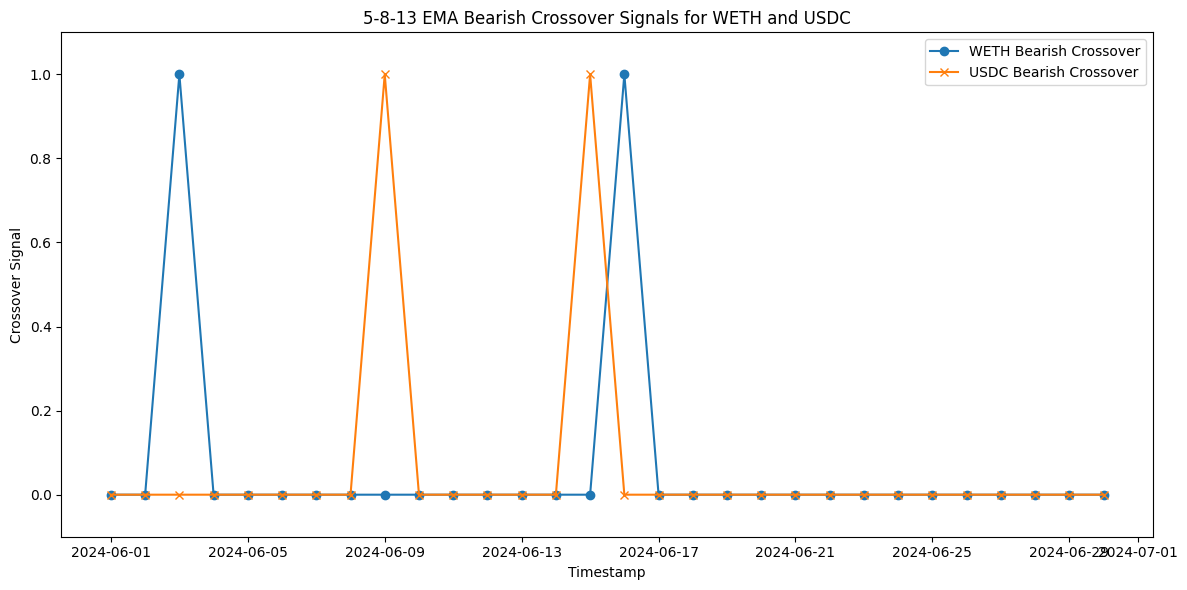

In [12]:
# --- Visualization ---

plt.figure(figsize=(12, 6))

# Plot the bearish crossover signals for WETH (filtered data)
plt.plot(daily_df['timestamp'], daily_df['weth_bearish_crossover'].astype(int), label='WETH Bearish Crossover', marker='o')

# Plot the bearish crossover signals for USDC (filtered data)
plt.plot(daily_df['timestamp'], daily_df['usdc_bearish_crossover'].astype(int), label='USDC Bearish Crossover', marker='x')

# Set plot labels and title
plt.xlabel('Timestamp')
plt.ylabel('Crossover Signal')
plt.title('5-8-13 EMA Bearish Crossover Signals for WETH and USDC')
plt.legend()

# Set y-axis limits
plt.ylim(-0.1, 1.1)

# Show the plot
plt.tight_layout()
plt.show()

The 5-8-13 EMA bearish crossover suggests four times (2 for WETH and 2 for USDC) when the price goes down.
In fact, if you scroll up again for the price trend graph, you could see that in the same positions there is a price drop.

The EMA and other indicators are often complemented by measuring the **ADX**. The ADX is a lagging indicator, so it is best used in conjunction with other indicators to confirm trends.   
The typical interpretation of ADX values is:
- ADX > 25: **Strong trend**
- ADX < 20: **Weak or no trend**

In [22]:
adx_df = df[['timestamp', 'WETH', "USDC"]]

# Convert the 'timestamp' column to datetime objects
adx_df['timestamp'] = pd.to_datetime(adx_df['timestamp'])

# Set 'timestamp' as the index
adx_df = adx_df.set_index('timestamp')

# Resample to daily frequency and calculate the opening, maximum, and closing values
def ohlc(x):
    return pd.Series({'WETH_low': x['WETH'].min(),
                      'WETH_max': x['WETH'].max(),
                      'WETH_close': x['WETH'].iloc[-1],
                      'USDC_low': x['USDC'].min(),
                      'USDC_max': x['USDC'].max(),
                      'USDC_close': x['USDC'].iloc[-1]})

adx_df = adx_df.resample('D').apply(ohlc).reset_index()

adx_df.head(5)

/var/folders/ch/f52gc87d5_7b95m4hg7qfbj80000gn/T/ipykernel_53810/3396798787.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adx_df['timestamp'] = pd.to_datetime(adx_df['timestamp'])


,timestamp,WETH_low,WETH_max,WETH_close,USDC_low,USDC_max,USDC_close
0,2024-06-01,3761.563153,3813.872765,3813.872765,0.998038,1.000690,1.000137
1,2024-06-02,3767.668382,3825.858530,3785.229342,0.999311,1.002602,0.999328
2,2024-06-03,3771.446764,3838.021727,3774.909954,0.997623,1.001965,0.999482
3,2024-06-04,3745.622306,3822.200657,3818.432072,0.998796,1.004104,1.000623
4,2024-06-05,3790.455527,3873.330017,3851.056672,0.998740,1.013684,0.999649


In [23]:
wethADX = ADXIndicator(adx_df['WETH_max'],adx_df['WETH_low'],adx_df['WETH_close'],14,False)
adx_df['weth_pos_directional_indicator'] = wethADX.adx_pos()
adx_df['weth_neg_directional_indicator'] = wethADX.adx_neg()
adx_df['weth_adx'] = wethADX.adx()

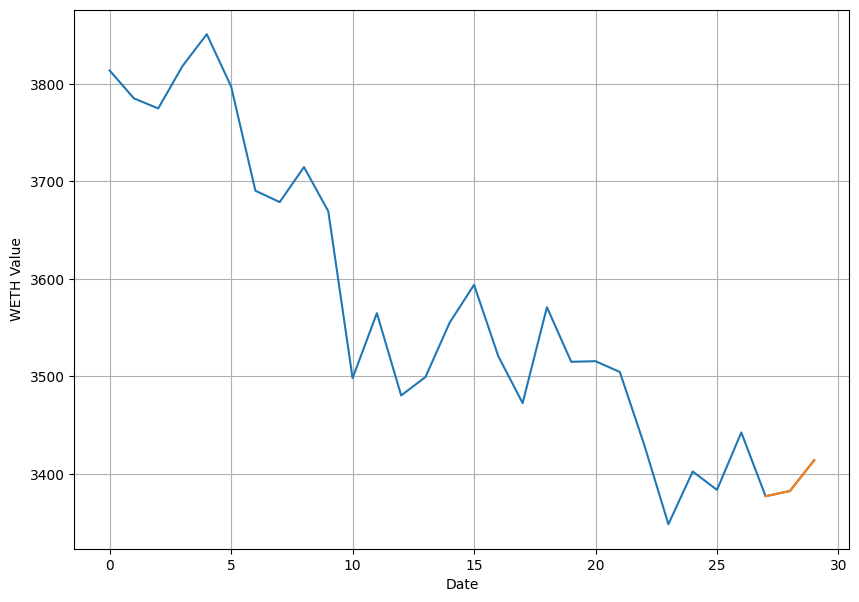

In [32]:
adx_df['trend'] = np.where(adx_df['weth_adx']>25,adx_df['WETH_close'],np.nan)
adx_df['trend_signal'] = np.where(adx_df['weth_adx']>25,1,0)
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(adx_df['WETH_close'])
plt.plot(adx_df['trend'])
plt.ylabel('WETH Value')
plt.xlabel('Date')
plt.show()

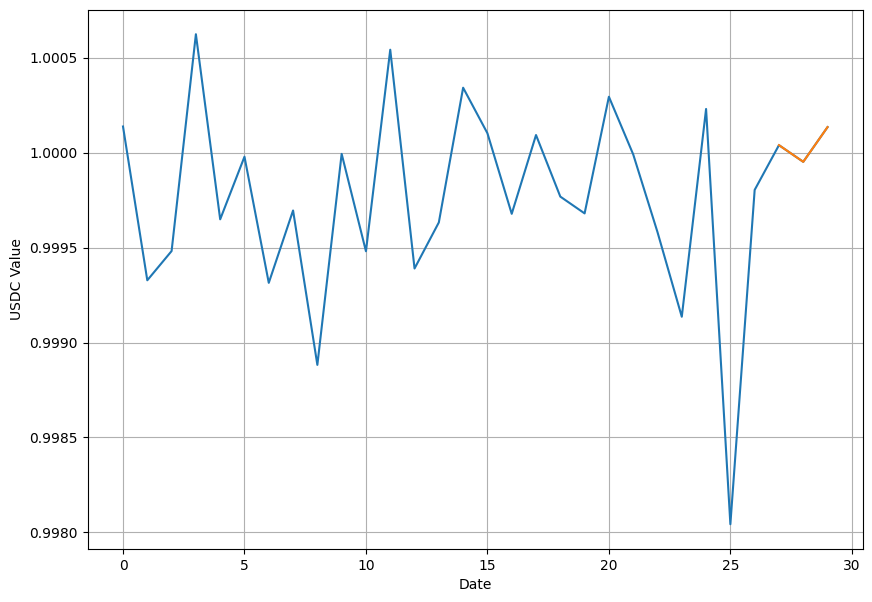

In [33]:
usdcADX = ADXIndicator(adx_df['USDC_max'],adx_df['USDC_low'],adx_df['USDC_close'],14,False)
adx_df['usdc_pos_directional_indicator'] = usdcADX.adx_pos()
adx_df['usdc_neg_directional_indicator'] = usdcADX.adx_neg()
adx_df['usdc_adx'] = usdcADX.adx()
adx_df['trend'] = np.where(adx_df['usdc_adx']>25,adx_df['USDC_close'],np.nan)
adx_df['trend_signal'] = np.where(adx_df['usdc_adx']>25,1,0)
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(adx_df['USDC_close'])
plt.plot(adx_df['trend'])
plt.ylabel('USDC Value')
plt.xlabel('Date')
plt.show()

The last two graphs proposed shows the daily trend for a token. The orange line suggests when the ADX is higher than 25.

### Conclusions
The market in July 2024 was relatively stable, with a decline in the value of tokens. It is reasonable to posit that an agent such as Proteus would be able to anticipate this and provide WETH tokens before the midpoint of the month. It should be noted that Proteus operates off-chain, employing the Demeter framework to backtest a strategy.
To continue to explore the Proteus project, please, run the script `2_simple_backtest.py`